# Convolutional neural network (CNN) for computer vision
![vision.png](attachments/vision.png)

Example applications 

* [Logo classification](https://data.vision.ee.ethz.ch/cvl/lld/)
* [Traffic sign classification](https://towardsdatascience.com/recognizing-traffic-signs-with-over-98-accuracy-using-deep-learning-86737aedc2ab)
* [Ecommerce product classification](https://www.kaggle.com/c/cdiscount-image-classification-challenge/data)
* [Medical image classification](https://www.kaggle.com/c/data-science-bowl-2017)
* [Food image classification](http://foodlg.com/)
* [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)
* [Real-time object detection](https://www.youtube.com/watch?v=mfB1C4QQJr4)
* [ImageNet classification](http://image-net.org/)


CNN refers to one set of machine learning model consists of multiple layers including convolution and pooling layers (to be introduced later). They are widely used as a **supervised learning** approach for **pattern recognition**. The training dataset consists of (x,y) pairs, where y is the label (list) of data sample x, e.g. the food name of the given picture, or the tags of an image, or the bounding boxes of all objects in an image. After training, for each new data sample, the model generates predictions for it.

In [1]:
%matplotlib inline
%reload_ext autoreload
import numpy as np
np.set_printoptions(precision=4, linewidth=100) #, suppress=True)

from matplotlib import pyplot as plt
plt.gray()

## CNN for MNIST image classification

Let's first take a look at how CNN make predictions.
[MNIST](http://yann.lecun.com/exdb/mnist/) is a small benchmark dataset, which has images of digits as shown below (the digit on the top is the label of the image). I have trained a simple CNN model against this dataset using 60,000 training images (6,000 images per class).


![mnist-sample.png](attachments/mnist-sample.png)

Load the test dataset (10,000) images.

In [2]:
from keras.datasets import mnist
from mnist_cnn import MnistCNN
import random 


# prepare test data
(_,_), (x, _) = mnist.load_data()
x = x[random.sample(range(x.shape[0]), 4)]
x.shape

Using TensorFlow backend.


(4, 28, 28)

Create the CNN model (details to be introduced later) and initialize it with the weights trained before.
The model accepts images organized in batch format. Hence, we do predictions for the 4 sample images together.

In [3]:
# load model
model = MnistCNN()
model.load_weights('ckpt/mnist_cnn.h5')

# make prediction
preds = model.predict(x, batchsize=x.shape[0])
print(preds)

[[  3.5424e-06   9.9247e-01   5.6497e-05   1.0267e-04   1.4154e-05   4.8722e-04   1.4048e-03
    1.2287e-06   5.4547e-03   2.1184e-06]
 [  5.4736e-04   8.3968e-03   1.5691e-03   6.9356e-03   1.6306e-04   2.7158e-02   2.0826e-02
    7.2818e-05   9.3418e-01   1.5353e-04]
 [  6.2635e-08   1.5673e-07   2.9358e-07   9.9966e-01   1.3606e-08   1.6470e-04   4.1768e-11
    2.0152e-06   1.0563e-04   7.1319e-05]
 [  1.3275e-04   1.3061e-03   4.3253e-03   3.1449e-02   1.7171e-02   4.1697e-02   1.5118e-03
    4.6704e-03   8.3681e-01   6.0929e-02]]


The prediction for each image has 10 values summing up to 1. The k-th value is the probability of assigning the k-th label to the input image.

Select the label with the largest probability and plot the originl image with the predicted label on top of it.

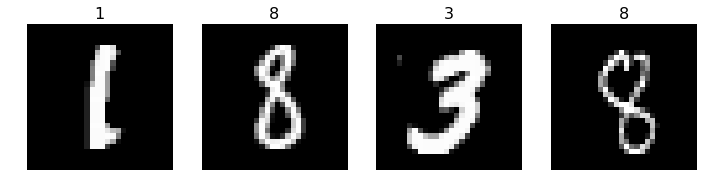

In [4]:
from utils import plots

# get top-1 prediction as the result
idxs = np.argmax(preds, axis=1)
plots(x, titles=idxs)

The model made correct predictions for all 4 images! The label on the top of each image is not from the data; Instead it is predicted by the model. This is NOT an easy task!


<img src="https://imgs.xkcd.com/comics/tasks_2x.png" width="300px"/>



Let's see what the model looks like.

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Now let's construct the above model using keras's [Sequential model API](https://keras.io/getting-started/sequential-model-guide/). It stacks all layers by the *add* operation.

To see the API (arguments) of each layer,
1. execute the cell
2. move the curse to the layer name, e.g. after 'Conv2D('
3. Tap 'Tab' + 'Shift' on your keyborad together for multiple times

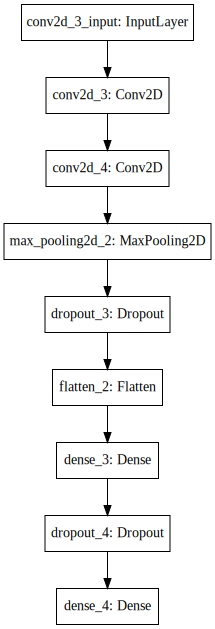

In [5]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D

# for image height and width
H = W = 28

def create_mnist_cnn(size, num_classes):
    mcnn = Sequential()
    mcnn.add(Conv2D(32, kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=(size, size, 1)))
    mcnn.add(Conv2D(64, (3, 3), activation='relu'))
    mcnn.add(MaxPooling2D(pool_size=(2, 2)))
    mcnn.add(Dropout(0.25))
    mcnn.add(Flatten())
    mcnn.add(Dense(128, activation='relu'))
    mcnn.add(Dropout(0.5))
    mcnn.add(Dense(num_classes, activation='softmax'))
    return mcnn

model = create_mnist_cnn(H, 10)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Covolution and pooling layers

Let's see what operation of convolution layers conduct.
Convolution in CNN refers to [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation), which is different to convolution in other domains. 


**1D Convolution**

![1d-conv.png](attachments/1d-conv.png)


Convolution VS MLP

Convolution has the following advatanges compared with the fully connected linear transformation in MLP models.
* Sparse connection and weight sharing --> fewer parameters
* Weight sharing --> fewer parmeters and location invariant
    
![cnn-mlp.png](attachments/cnn-mlp.png)


** 2D convolution **
<img src="http://deeplearning.net/software/theano/_images/numerical_no_padding_no_strides.gif">


[Interactive example](http://setosa.io/ev/image-kernels/)




2D convolution example 1
* receptive field size = kernel size = (3, 3)
* input feature map size = (4, 4)
* output feature map size = (2, 2)
* padding size = 0
* stride size = 1

<img src="http://deeplearning.net/software/theano/_images/no_padding_no_strides.gif">

2D Convolution example 2
* receptive field size = kernel size = (3, 3)
* input feature map size = (5, 5)
* output feature map size = (5, 5)
* padding size = 2
* stride size = 1
<img src="http://deeplearning.net/software/theano/_images/same_padding_no_strides.gif">


2D Convolution example 3
* receptive field size = kernel size = (3, 3)
* input feature map size = (5, 5)
* output feature map size = (2, 2)
* padding size = 0
* stride size = 2
<img src="http://deeplearning.net/software/theano/_images/no_padding_strides.gif">



** 2D convolution with multiple channels (kernels)**

![rgb-conv.png](attachments/rgb-conv.png)


**Pooling**
* max pooling
* average pooling

![max-pool.png](attachments/max-pool.png)

**Summary**
* Convolution operation multiplies each kernel with each recpetive field to generate an output neuron.
* Pooling operation do an aggregation over each receptive field to generate an output neuron
* The output feature map size is 

$$(f, \frac{\lfloor h+p_h-k_h\rfloor}{s_h} + 1, \frac{\lfloor w+p_w-k_w\rfloor}{s_w} + 1)$$
* f is the number of kernels
* h is the height of the input feature map, $$p_h, k_h, s_h$$ are the padding, kernel and stride size along the vertical side
* w is the width of the input feature map, $$p_w, k_w, s_w$$ are the padding, kernel and stride size along the horizontal side

The total number of parameters of the convolution layer is

$$f \times c \times k_h \times k_w$$
where c is the number of input feature maps

**Training and evaluation **

Lode the training data and normalize each pixel. There are a couple of [popular normalization approaches](https://keras.io/preprocessing/image/).

In [6]:
import keras

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 
                          x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 
                        x_test.shape[2], 1)
# input_shape = (1,  x_train.shape[1], x_trian.shape[2])


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_train sample:', x_train[0, 15:20, 15:20,:])


# convert class vectors to binary class matrices
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_test shape:', y_test.shape)
print('y_test sample:', y_test[0])

x_train shape: (60000, 28, 28, 1)
x_train sample: [[[ 0.7294]
  [ 0.9922]
  [ 0.9922]
  [ 0.5882]
  [ 0.1059]]

 [[ 0.0627]
  [ 0.3647]
  [ 0.9882]
  [ 0.9922]
  [ 0.7333]]

 [[ 0.    ]
  [ 0.    ]
  [ 0.9765]
  [ 0.9922]
  [ 0.9765]]

 [[ 0.5098]
  [ 0.7176]
  [ 0.9922]
  [ 0.9922]
  [ 0.8118]]

 [[ 0.9922]
  [ 0.9922]
  [ 0.9922]
  [ 0.9804]
  [ 0.7137]]]
y_test shape: (10000, 10)
y_test sample: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


Mini-batch SGD is the default optimization algorithm for training CNN models.
It updates the model parameters iteratively to miminize the training loss.
The loss function measures the discrepancy between the model prediction and the ground truth labels.
For example, softmax and cross entropy are usually combined for image classification tasks. In keras, 
it is called categorical_crossentropy.

$$L(x, y) = -y_i log p_i$$
where $p_i$ is the probability for the i-th label.

For each iteration, it works as 
$$w=w-\alpha \frac{\partial L}{\partial w}$$
where $L$ is the loss function, $w$ is the parameter (matrix), 
$\alpha$ is the learning rate which controls the update scale.

Advanced SGD algorithm adopts adaptive learning rate, 
i.e. each parameter scala has its own learning rate instead of a single learning rate for all parameters.


$\frac{\partial L}{\partial w}$ is computed using [Back-propagation](http://colah.github.io/posts/2015-08-Backprop/) algorithm, which exploits chain-rule to compute 
the partial gradient of the loss with respect to (r.w.t) the parameters in the layers, from top-layer to bottom-layer.

$$h_i=f_i(h_{i-1}, w_i)$$
$$\frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial h_n} \frac{\partial h_n}{\partial h_{n-1}} ... \frac{\partial h_i}{\partial w_i}$$

Loss function, SGD and BP are implemented in deep learning software. Users just need to configure them.

T1: training with vanilla SGD

In [7]:
batch_size=128
nb_epoch = 60

In [8]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(0.01, 0.9),
              metrics=['accuracy'])

t1 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=1,
          validation_data=(x_test, y_test))
# model.save_weights('ckpt/mnist_cnn.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 7s 122us/step - loss: 0.4880 - acc: 0.8462 - val_loss: 0.1470 - val_acc: 0.9565
Epoch 2/60
60000/60000 [==============================] - 7s 110us/step - loss: 0.1884 - acc: 0.9436 - val_loss: 0.0815 - val_acc: 0.9745
Epoch 3/60
60000/60000 [==============================] - 6s 107us/step - loss: 0.1270 - acc: 0.9621 - val_loss: 0.0561 - val_acc: 0.9821
Epoch 4/60
60000/60000 [==============================] - 6s 108us/step - loss: 0.1006 - acc: 0.9690 - val_loss: 0.0492 - val_acc: 0.9839
Epoch 5/60
60000/60000 [==============================] - 7s 114us/step - loss: 0.0842 - acc: 0.9745 - val_loss: 0.0384 - val_acc: 0.9872
Epoch 6/60
60000/60000 [==============================] - 7s 113us/step - loss: 0.0742 - acc: 0.9776 - val_loss: 0.0375 - val_acc: 0.9876
Epoch 7/60
60000/60000 [==============================] - 6s 105us/step - loss: 0.0662 - acc: 0.9794 - val_loss: 0.0359 - 

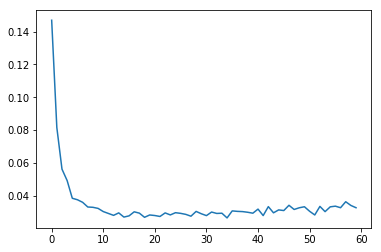

In [9]:
plt.plot(t1.epoch, t1.history['val_loss'])

[CNN Training tips and tricks](http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html)

1. Data. [Data augmentation](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)
2. Model. 
  * Activation
  * Batch normalization
  * Architecture
3. Optimization 
  * SGD algorithm
  * Learning rate
  * Batch size
  * Random shuffle
4. Regularization
  * Dropout
  * L2 norm


T2: Training with a larger learning rate (0.1)

In [11]:
model = MnistCNN().model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(0.1, 0.9),
              metrics=['accuracy'])

t2 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=0,
          #callbacks=[keras.callbacks.LearningRateScheduler(lr)],
          validation_data=(x_test, y_test))
# model.save_weights('ckpt/mnist_cnn.h5')


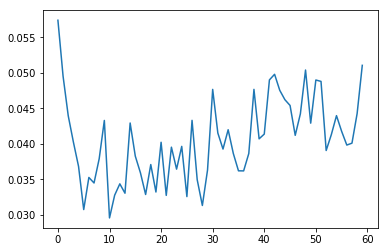

In [12]:
plt.plot(t2.epoch, t2.history['val_loss'])

T3: training with decaying learning rate

In [13]:
model = MnistCNN().model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(0.1, 0.9),
              metrics=['accuracy'])
def lr(e):
    return 0.1 * pow(0.1, e // 15)


t3 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=0,
          callbacks=[keras.callbacks.LearningRateScheduler(lr)],
          validation_data=(x_test, y_test))
# model.save_weights('ckpt/mnist_cnn.h5')

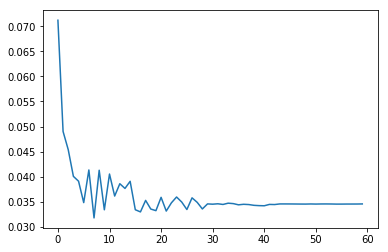

In [14]:
plt.plot(t3.epoch, t3.history['val_loss'])

T4: training with adaptive learning rate
    

In [15]:
model = MnistCNN().model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

t4 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=0,
          validation_data=(x_test, y_test))

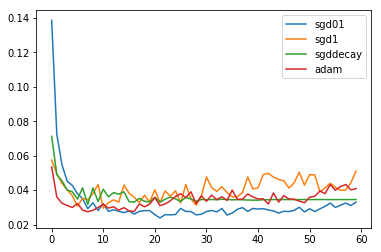

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
for t, label in zip([t1, t2, t3, t4], ['sgd01', 'sgd1', 'sgddecay', 'adam']):
    ax.plot(t.epoch, t.history['val_loss'], label=label)
plt.legend()
plt.show()

### Optimization is difficult!

A MLP with one hidden layer is an [universal approximator](https://en.wikipedia.org/wiki/Universal_approximation_theorem).
But it is difficult to optimize to a good point, compared with CNN which has many regularizations.

## Assignment 1

Training with batch normalization layer. 


In [17]:
def create_mnist_cnn_bn(size, num_classes):
    """TODO: create the CNN with batch normalization layer after each conv layer"""
    pass 

def train_bn():
    model = create_mnist_cnn_bn(H, 10)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    t4 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              verbose=0,
              validation_data=(x_test, y_test))

Training with image augmentation

In [18]:
def train_bn_aug():
    model = create_mnist_cnn_bn(H, 10)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    # TODO use model.fit_generator() and ImageDataGenerator()
    pass 

In [19]:
del x_train, y_train, y_test, x_test

**Prediction**

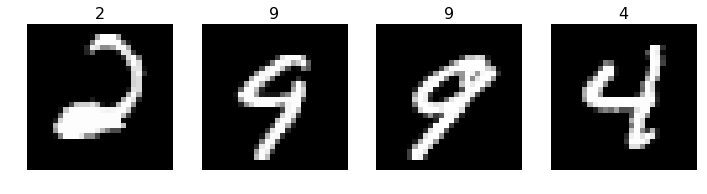

In [20]:
# prepare test data
_, (x_test, _) = mnist.load_data()
samples = x_test[random.sample(range(x_test.shape[0]), 4)]
x = samples.astype('float32')
# reshape the batch; keras Conv layer expects x with 4 dimensions (the last one as the channels dimension)
x = x.reshape(x.shape[0], H, W, 1)
x /= 255 # normalize the images
preds = model.predict(x, x.shape[0])

# get top-1 prediction as the result
idxs = np.argmax(preds, axis=1)
plots(samples, titles=idxs)
del x_test

### CNN architectures
CNN timeline
![cnn.png](attachments/cnn.png)


Popular CNN architectures
* AlexNet
* VGG
* InceptionNet (GoogleNet)
* ResNet
* DenseNet
* XceptionNet
* SqueezeNet

![cnns.png](attachments/cnns.png)


In [10]:
from keras.applications.resnet50 import ResNet50, decode_predictions
#from keras.applications.vgg16 import VGG16


model = ResNet50()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Fine-tune CNN for other classification tasks


CNN models are good at learning features from images for various tasks.
We can exploit the popular architectures in two ways,
1. as feature extractor: extract features of images by feeding images into the popular models and take the intermediate layers as the output
2. as a starting model for our own tasks: fine-tune the models parameters over our own datsets. 

Tips from [cs291n](http://cs231n.github.io/transfer-learning/)

![transfer-lr.JPG](attachments/transfer-lr.JPG)

**Dog VS Cat**

Download and unzip the [train.zip](https://www.kaggle.com/c/dogs-vs-cats/data). Put the images into `data/dog-cat/train` folder. Then randomly put some images from the training dataset into validation dataset by (the PWD is `data/dog-cat`)

```
mkdir dog
mkdir cat
mv train/dog.* dog/
mv train/cat.* cat/
mv dog train/
mv cat train/
mkdir valid
mkdir valid/cat 
mkdir valid/dog
shuf -n 5000 -e ../train/dog/* | xargs -i mv {} dog/
shuf -n 5000 -e ../train/cat/* | xargs -i mv {} cat/
```

In [22]:
from utils import reorganize_dog_cat
# run this just once
# reorganize_dog_cat("data/dog-cat")

Data preparation

Found 19984 images belonging to 2 classes.


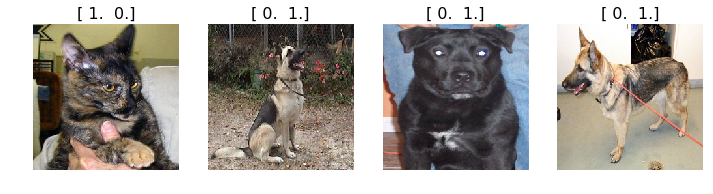

In [11]:
from keras.preprocessing import image


channel_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))

def preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (channels x width)
        Returns:
            Image array (transposed_channels x height x width)
    """
    x = x - channel_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def get_batches(dirname,  shuffle=True, batch_size=32, class_mode='categorical', vis=False):
    """
        Takes the path to a directory, and generates batches of augmented/normalized data. 
        Yields batches indefinitely, in an infinite loop.
        See Keras documentation: https://keras.io/preprocessing/image/
    """    
    path = 'data/dog-cat/'
    if vis:        
        return image.ImageDataGenerator().flow_from_directory(
            path + dirname, target_size=(224,224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)
    else:
        return image.ImageDataGenerator(preprocessing_function=preprocess).flow_from_directory(
            path + dirname, target_size=(224,224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches('train', batch_size=4, vis=True)
imgs, labels = next(batches)
# This shows the 'ground truth'
plots(imgs, titles=labels)

Get training and validation data generator

In [18]:
batch_size = 32
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', shuffle=False, batch_size=batch_size)

classes = {}
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c 
print(classes)

Found 19984 images belonging to 2 classes.
Found 5016 images belonging to 2 classes.
{0: 'cat', 1: 'dog'}


Use ResNet directly for prediction

In [21]:
x, y = next(batches)
preds = model.predict(x, x.shape[0])
decode_predictions(preds, 1)[0]
preds = [yi[0][1] for yi in decode_predictions(preds, 1)[0:10]]
truth = ['dog' if yi==1 else 'cat' for yi in np.argmax(y[0:10], axis=1)]
print("          Predictions           VS    Ground truth")
for (p, t) in zip(preds, truth):
    print('%30s' %p, '%10s' % t)

          Predictions           VS    Ground truth
                    bloodhound        dog
                         tabby        cat
                    Great_Dane        dog
                  Egyptian_cat        cat
                       clumber        dog
                       polecat        dog
                   Persian_cat        cat
                      papillon        cat
                        basset        dog
                    Great_Dane        dog


Keras functional API

In [26]:
from keras.models import Model
from keras.layers import Input, Dense

a = Input(shape=(32,))
b = Dense(32)(a)
model = Model(inputs=a, outputs=b)

Fine-tune the ResNet for our own task
1. modify the network structure to generate predictions for two classes
2. fix some layers (how many?)

In [22]:
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import Model

resnet = ResNet50()
# fix all layers
for layer in resnet.layers[0:10]: layer.trainable=False 
x = resnet.outputs[-1]
x = Dense(2, activation='softmax')(x)
model = Model(input=resnet.inputs, outputs=x)

/media/hd1/home/wangwei/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


Conduct training

In [23]:
model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.fit_generator(batches, 
                    steps_per_epoch=batches.samples // batch_size, 
                    epochs=10, 
                    validation_data=val_batches, 
                    validation_steps=val_batches.samples // batch_size)

Epoch 1/10
625/624 [==============================] - 134s 214ms/step - loss: 0.6080 - acc: 0.8817 - val_loss: 0.5334 - val_acc: 0.9079
Epoch 2/10
625/624 [==============================] - 136s 217ms/step - loss: 0.4853 - acc: 0.9075 - val_loss: 0.4351 - val_acc: 0.9097
Epoch 3/10
625/624 [==============================] - 136s 217ms/step - loss: 0.4069 - acc: 0.9098 - val_loss: 0.3717 - val_acc: 0.9101
Epoch 4/10
625/624 [==============================] - 136s 217ms/step - loss: 0.3527 - acc: 0.9139 - val_loss: 0.3281 - val_acc: 0.9129
Epoch 5/10
625/624 [==============================] - 135s 216ms/step - loss: 0.3166 - acc: 0.9153 - val_loss: 0.2969 - val_acc: 0.9171
Epoch 6/10
625/624 [==============================] - 135s 215ms/step - loss: 0.2865 - acc: 0.9177 - val_loss: 0.2734 - val_acc: 0.9199
Epoch 7/10
625/624 [==============================] - 136s 217ms/step - loss: 0.2663 - acc: 0.9192 - val_loss: 0.2566 - val_acc: 0.9211
Epoch 8/10
625/624 [============================

In [44]:
preds = model.predict(imgs)
idxs = np.argmax(preds, axis=1)    
for i in range(len(idxs)):
    idx = idxs[i]
    print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

  0.9648/cat
  0.8538/dog
  0.9993/cat
  0.9745/cat


In [53]:
val_batches = get_batches('valid', shuffle=False, batch_size=batch_size)
preds = model.predict_generator(val_batches, steps=100)
preds.shape

Found 5016 images belonging to 2 classes.


(5016, 2)

[[2352  144]
 [ 212 2308]]


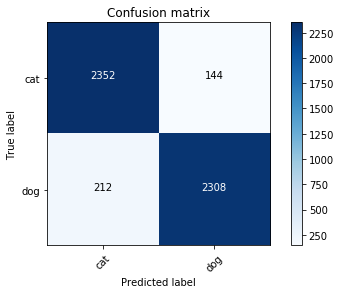

In [54]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

cm = confusion_matrix(val_batches.classes, np.argmax(preds, axis=1))
plot_confusion_matrix(cm, val_batches.class_indices)

# CNN for natural language processing (NLP)

Consecutive words within one sentence usualy have correlations.
CNN can be applied to extract such local correlation for NLP tasks.


![cnn-senti.png](attachments/cnn-senti.png)

## Sentiment analysis of moive reviews

In [10]:
from keras.preprocessing import sequence
from keras.layers import Embedding, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')


Loading data...
25000 train sequences
25000 test sequences


Data samples

In [11]:
idx_word = dict((i, w) for (w, i) in imdb.get_word_index().items())

for i, sentence in enumerate(x_train[0:3]):
    print(x_train[i][0:10])
    print(' '.join([idx_word[x-3] for x in sentence[0:10] if x > 2]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
this film was just brilliant casting location scenery story
[1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463]
big hair big bad music and a giant
[1, 14, 47, 8, 30, 31, 7, 4, 249, 108]
this has to be one of the worst films


In [12]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [13]:
print('Build model...')
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))


# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0     

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
        validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s 507us/step - loss: 0.4047 - acc: 0.8009 - val_loss: 0.3034 - val_acc: 0.8712
Epoch 2/2
25000/25000 [==============================] - 12s 479us/step - loss: 0.2324 - acc: 0.9055 - val_loss: 0.3033 - val_acc: 0.8728


In [15]:
preds = model.predict(x_test[0:5], batch_size=5)
for i, sentence in enumerate(x_test[0:5]):
    print(' '.join([idx_word[x-3] for x in sentence if x > 2]), preds[i])

please give this one a miss br br and the rest of the cast terrible performances the show is flat flat flat br br i don't know how michael could have allowed this one on his he almost seemed to know this wasn't going to work out and his performance was quite so all you fans give this a miss [ 0.0127]
this film requires a lot of because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in the dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere with sexual tension and psychological it's very interesting that robert directed this considering the style and structure of his other films still the audio style is evident here and there i think what really makes this film work is the brilliant performance by dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the young man 

## Assignment 2

Fine tune any popular CNN architecture over the one image dataset listed [here](http://wiki.fast.ai/index.php/Image_Datasets)